# Visual Analysis of Attacking an Idle Drone (20m Offset, 4m/s/s Strength)
In this data the drone is set to loiter in the air at an approximate height of
8m and set to hold position, altitude, and attitude. The GPS spoofing attack
written into the autopilot is enabled by controller with the target offset of
20m with a strength depending on the parameters. The collected data includes
a strength of 1m/s/s, 2m/s/s, and 4m/s/s, identified by the naming scheme
Live-C-Idle-Attack-`offset`-`strength`.log. The data files can be found
in the data subdirectory. Only interim data will be available on github to
preserve storage. For raw log files please contact me at
srimoungchanh.bailey@ku.edu.


For additional information about each sensor pair used in confirmation or a
more detailed explanation of the process refer to the
[exploration notebook](./0.1-bks-exploration.ipynb) using simulation data.

## Data Processing
The log `file` needs to be parsed out as the format is irregular, starting with
a csv of rows prefixed with FMT, indicating the log type and format. The FMT
rows will be parsed into headers and then the subsequent rows will be matched
on log name, i.e., "__SNS1__", "__SNS2__", "__SNS3__" and added to their
respective dataframes. The dataframes are then unioned on their timestamps to
create a single dataframe with all of the __SNS__ data. If an `output` path is
provided the newly created dataframe will be written to the path as a CSV.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import numpy as np
from confirmation.process import process_SNS
from os.path import exists

#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Live-C-Idle-Attack-2000-4.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

## Gyroscope, Magnetometer, and Optical Flow

#### Magnetometer and Gyroscope Heading
__Important details to keep in mind:__

* Gyroscope only provides relative yaw so the
initial value is aligned to the initial magnetometer readings and integrated
from there.

* Magnetometer and Gyroscope are both only using their own readings with no
filter but there may be manufacturer specific offsets or scaling to get usable
data. Refer to ArduPilot 
[AP_AHRS](https://github.com/ArduPilot/ardupilot/tree/master/libraries/AP_AHRS)
and
[AP_Compass](https://github.com/ArduPilot/ardupilot/tree/master/libraries/AP_Compass)
libraries for more details.

For functions used in calculating heading from gyroscope and magnetometer refer
to the [process.py](../src/confirmation/process.py) file. Further details about
why certain sensors need to be processed a particular way to get confirmable
information is provided in the exploration notebook linked under the title.

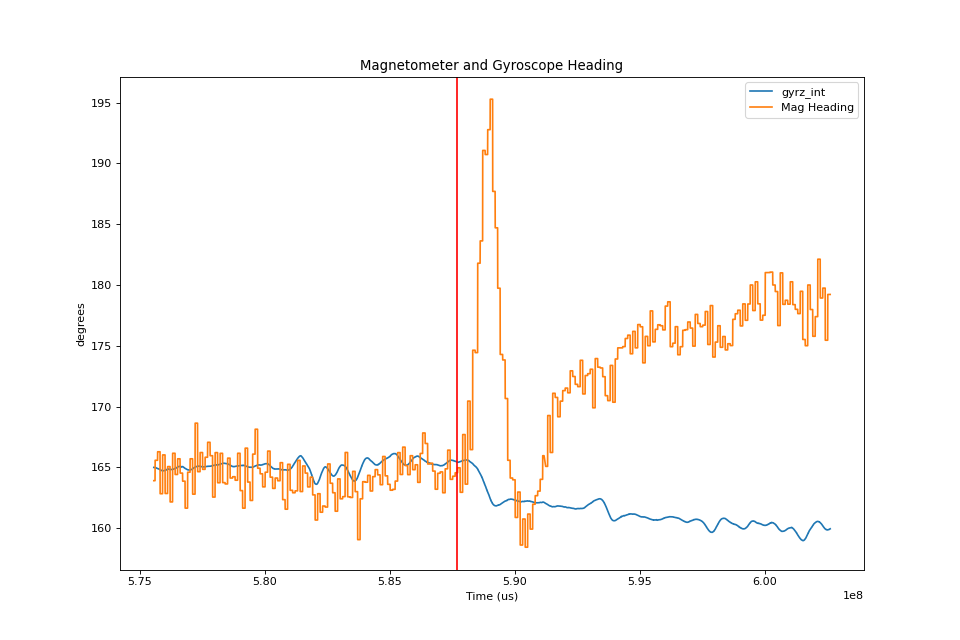

In [2]:
from confirmation.process import trap_integrate, mag_to_heading
from confirmation.visualize import simple_time_plot
from math import degrees

mag_heading = mag_to_heading(df.magz, df.magy, df.magx)
gyr_heading = trap_integrate(df.cUS / 1000000, df.gyrz).apply(degrees).cumsum() % 360
simple_time_plot(df.TimeUS[1:],
                 [(gyr_heading-195) % 360,
                  (mag_heading[1:]-180) % 360],
                 ['us', 'degrees'],
                 title="Magnetometer and Gyroscope Heading",
                 atk=587680045)

Initially this result looks poor because the assumption is that since the GPS
is being spoofed the heading calculated from other sensors would be unaffected
and thereby still confirm correctly. An important consideration however is how
spoofing the GPS may lead to impacting not the physical characteristic derived
from a sensor but rather the phenomenon being read by the sensor itself. 
Spoofing the GPS causes the quadcopter to vary the RPM of the motors changing
the battery drain sporadically thereby altering the magnetic field around the
quadcopter; indirectly impacting the magnetometer derived heading. The graph
provided by UAV log viewer displayed below marks the spike in magnetometer
readings which comes immediately after GPS spoofing which starts at 587 seconds
.

![heading_mag_gyro](../reports/figures/Heading_Mag_Gyro_Attack.PNG)

#### Magnetometer and Gyroscope Pitch
__Important details to keep in mind:__

* Gyroscope only provides relative yaw so the
initial value is aligned to the initial magnetometer readings and integrated
from there.

* Magnetometer and Gyroscope are both only using their own readings with no
filter but there may be manufacturer specific offsets or scaling to get usable
data. Refer to ArduPilot 
[AP_AHRS](https://github.com/ArduPilot/ardupilot/tree/master/libraries/AP_AHRS)
and
[AP_Compass](https://github.com/ArduPilot/ardupilot/tree/master/libraries/AP_Compass)
libraries for more details.

For functions used in calculating pitch from gyroscope and magnetometer refer
to the [process.py](../src/confirmation/process.py) file. Further details about
why certain sensors need to be processed a particular way to get confirmable
information is provided in the exploration notebook linked under the title.

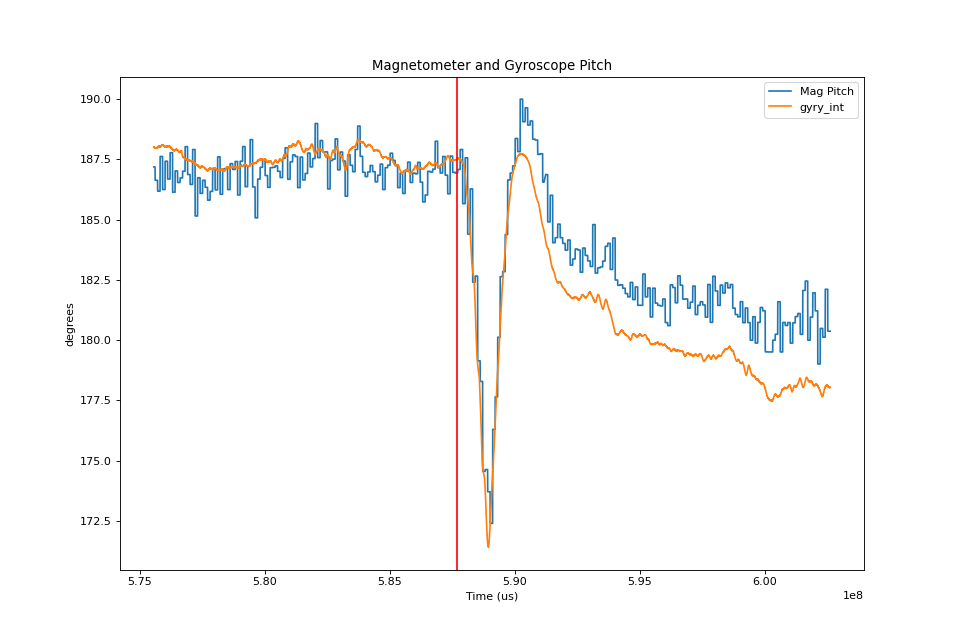

In [3]:
from confirmation.process import mag_to_pitch

#Gyroscope pitch, same as before with heading
gyr_pitch = trap_integrate(df.cUS / 1000000, df.gyry).apply(degrees).cumsum() % 360

#Magnetometer pitch
mag_pitch = mag_to_pitch(df.magz, df.magy, df.magx)
simple_time_plot(df.TimeUS[1:],
                 [mag_pitch[1:],
                  (gyr_pitch+188)%360],
                 ["us","degrees"],
                 title="Magnetometer and Gyroscope Pitch",
                 atk=587680045)

The point in which the drone pitches is when the attack begins. In order to
move around, in response to the attack, the drone has to pitch which is
seen at the dip in the results at 5.87 seconds. We had mentioned before that
the attack caused changes in the magnetic field that were observable in the
heading calculated before but it would appear that the pitch was unaffected.
The lack of spiking in magnetometer data could either mean the readings in the
heading were a fluke and the attack is not observable in unrelated sensor
results or that the only axis of the magnetic field impacted by the quadcopters
response was related to the heading. The axis of the magnetic field being
impacted can be verified by looking at the plot of all three magnetic fields.
Displayed below is this plot:

![mag_field](../reports/figures/Mag_Field_During_GPS_Attack.png)

As can be seen in the above figure, only the x axis of the magnetic field was
impacted which clarifies why the heading was impacted but the pitch wasn't.
Heading calculations use the x and y axis of the magnetic field but pitch
calculations use the y and z axis.

## GPS specific
Looking at specifically the GPS sensor there isn't an inherent value being
measured that can be directly compared to inertial sensors such as angular
rate. Instead, we will take a look at the different ways a GPS can be confirmed
even if each sensor pairing does not have an application to another sensor
pair. An example of this is using a barometer to confirm the GPS height
estimate while using the magnetometer to confirm the GPS heading (assuming
conditions are met).

__GPS__ provides positional data which is derived from information provided by
satellites and the signals used to transmit that information. A consequence of
using several satellites for position calculation is the absolute measurements
will have less accuracy depending on world model but the relative measurements
will still have decent accuracy. Below will be a list of confirmations we will
explore in this:

| **Measurement**             | **Rangefinder** | **Barometer** | **Magnetometer** | **Gyroscope** | **RF & OF** |   **Accelerometer &  (Gyroscope \|\| Magnetometer)**|
|-----------------------------|-----------------|---------------|------------------|---------------|-------------|-----------------------------------------------------|
| Above-Ground-Level Distance |      **x**      |     **x**     |                  |               |    **x**    |                        **x**                        |
| Heading                     |                 |               |       **x**      |     **x**     |             |                        **x**                        |
| Speed                       |                 |               |                  |               |    **x**    |                        **x**                        |

### Above-Ground-Level Distance
__Important details to keep in mind:__

* Barometer measures pressure and calculates altitude relative to another
barometer measurement.

* Rangefinder and the accelerometer are both susceptible to attitude. The
rangefinder reads whatever the laser sensor mounted on the bottom of the
quadcopter is pointed at which when the quadcopter is at an angle becomes
skewed. The accelerometer by itself can only correctly read the downward
direction when the platform is level, otherwise the body frame and ECEF frame
become misaligned and the downward readings become incorrect.

* GPS altitude readings are most likely the most accurate of the collection of
sensors but has more restrictions in use such as satellite count, terrain, 
relative readings, and filter health.


For functions used in cleaning up data refer to the
[process.py](../src/confirmation/process.py) file.

First we will look at the change in altitude rather than the raw altitude. This
approach has the benefit of ignoring the absolute altitude reading and focus on
the changes in the signal, avoiding problems with calibration or initial biases
.

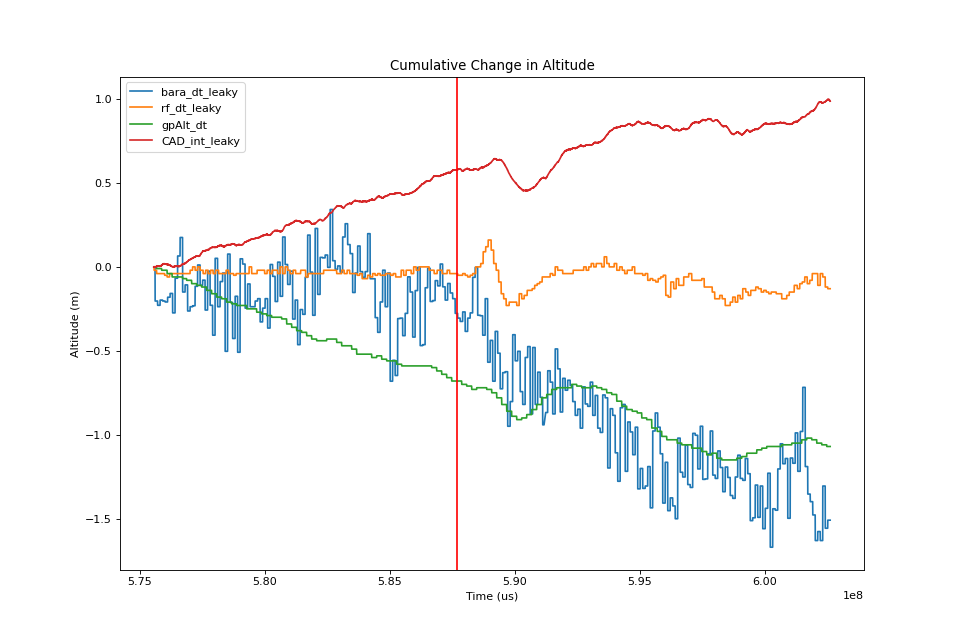

In [4]:
from confirmation.process import change_in_signal, leaky_integrator
#Need the change_in_signal function to compare change in the percieved altitude
#rather than the raw altitude. 

alpha = 1
acc_alt = leaky_integrator(trap_integrate(df.cUS/1000000, df["CAD"]), alpha)
bar_alt = leaky_integrator(change_in_signal(df.bara), alpha)
rf_alt = leaky_integrator(change_in_signal(df.rf/100), alpha)
gp_alt = change_in_signal(df.gpAlt/100)

simple_time_plot(df.TimeUS[1:],
                 [bar_alt.cumsum(),
                  rf_alt.cumsum(),
                  gp_alt.cumsum(),
                  acc_alt.cumsum()],
                 atk=587680045,
                title="Cumulative Change in Altitude",
                units=["us","Altitude (m)"])

We can see that the trends are relatively similar, especially after the attack
at ~5.87E8us where the sensors have a dip. There is a constant drift in the
sensors which is fairly normal and is usually corrected by in-flight bias done
by sensor fusion like a Kalman Filter. In this application we will take
advantage of having all of the data at once and remove the mean of the loiter
and consider in-flight biasing at another time.

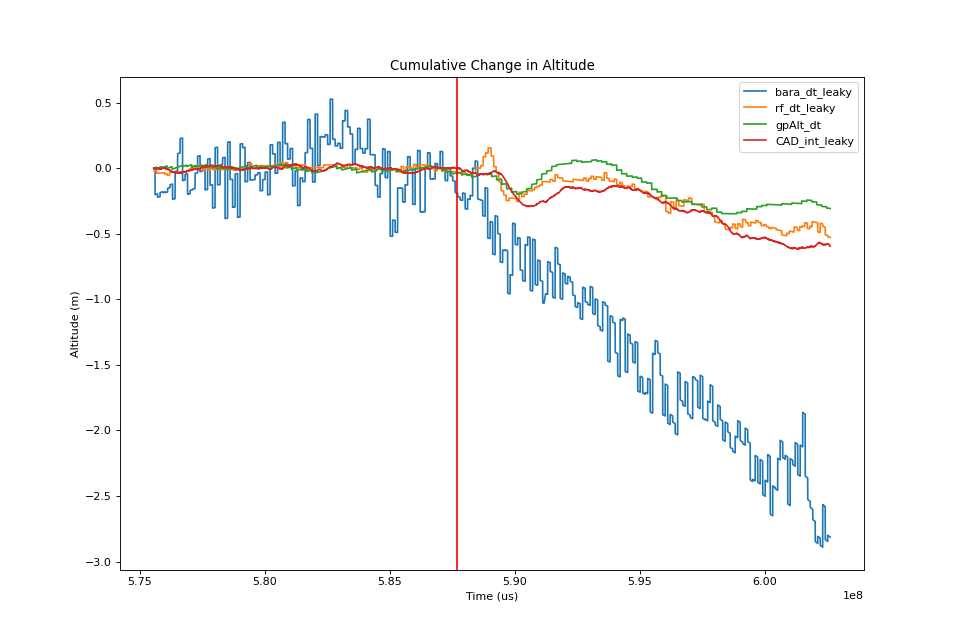

In [5]:
#linear_bias removes a percieved first order drift from the signal. In this
#case the index of time from 0:4573 represents the loiter portion of the
#mission without any attack
from confirmation.process import linear_bias

indices = [0, 4573]
simple_time_plot(df.TimeUS[1:],
                 [linear_bias(df.TimeUS[1:], bar_alt, indices).cumsum(),
                  linear_bias(df.TimeUS[1:], rf_alt, indices).cumsum(),
                  linear_bias(df.TimeUS[1:], gp_alt, indices).cumsum(),
                  linear_bias(df.TimeUS[1:], acc_alt, indices).cumsum()],
                 atk=587680045,
                title="Cumulative Change in Altitude",
                units=["us","Altitude (m)"])

Interestingly enough we get GPS, rangefinder, and accelerometer derived
altitude change to be within 0.5m over ~15 seconds during the attack. The
closeness of the results is heartening as the attack on the GPS actually passes
the real altitude readings through meaning these values should confirm. The
barometer drifts dramatically but some digging on the matter has turned up this
[github issue](https://github.com/PX4/PX4-Autopilot/issues/10058#issuecomment-425609238)
for ArduPilot where barometer drift was an issue and attributed to tilting
during movements flight causing pressure differences across top mounted flat
flight controllers like used in testing.

#### Windowing

A method for reducing low frequency noise, or a slow drifting bias, is to only
look at sections of the data over time. Methods for looking at sections of the
data can be referred to as filtering, moving averages, windowing, or so forth.
What was displayed before is the cumulative sum of changes meaning any change
in the signal whether due to noise or actual movement will forever be kept in
the result. A downside to summing all the changes is the difficulty of focusing
on similar patterns between signals. For instance, consider the downturn at 
~5.90E8us where all of the signals dip similarly. If we were to focus on the entire
signal then the difference between them would grow due to noise and most likely
trigger any static innovation or boundary test. If a window were to be
implemented to only observe the amount of data considered relevant to catching
discrepancies in behavior then the error margins could be static and drift due
to noise would no longer be a problem. The primary consideration here is how
large of a window of data to look at and whether this should be rigorously 
derived or heuristically from data. For this data exploration the heuristic
approach will be considered which is identified as the time frame of the dip,
2 seconds.

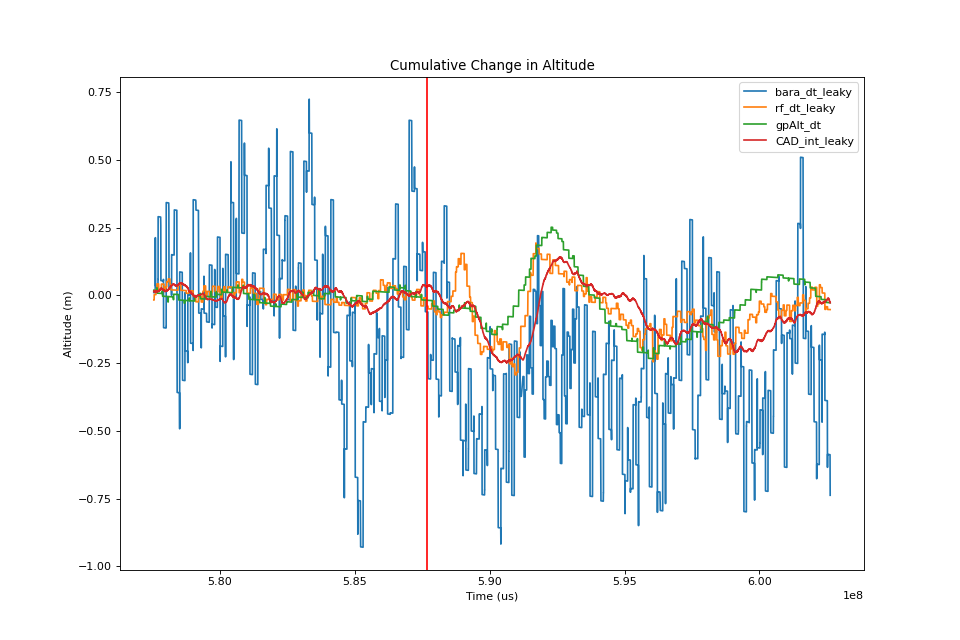

In [6]:
from math import floor

window_size = floor(2000000/df.TimeUS.diff().mean()) #Data points in 2s

indices = [0, 4573]
simple_time_plot(df.TimeUS[1:],
                 [linear_bias(df.TimeUS[1:], bar_alt, indices).rolling(window_size).sum(),
                  linear_bias(df.TimeUS[1:], rf_alt, indices).rolling(window_size).sum(),
                  linear_bias(df.TimeUS[1:], gp_alt, indices).rolling(window_size).sum(),
                  linear_bias(df.TimeUS[1:], acc_alt, indices).rolling(window_size).sum()],
                 atk=587680045,
                title="Cumulative Change in Altitude",
                units=["us","Altitude (m)"])

Windowing closed the gap between sensors significantly and provided a tighter
grouping. Unfortunately the barometer is still rather spiky but this is still
attributed to the pressure difference issue mentioned before when the
quadcopter starts tilting.

#### Statistics of These Signals Compared to Theory

Now that these signals are grouped well enough we can start looking at the
statistical details of the signals and how they relate to determine if sensor
confirmation would be possible here. The simplest approach taken is to take
the absolute difference in any 2 signals and determine at what value 99.7% of
the signals fall below. Finding where 99.7% of values fall under is the
sensor confirmation approach that wants to consider signal differences and
compare the result to datasheet reported or empirically derived noise
distributions.

In [7]:
rf = linear_bias(df.TimeUS[1:], rf_alt, indices).rolling(window_size).sum()
gps = linear_bias(df.TimeUS[1:], gp_alt, indices).rolling(window_size).sum()
acc = linear_bias(df.TimeUS[1:], acc_alt, indices).rolling(window_size).sum()

#### Benign Case

In [8]:
#Accelerometer compared to GPS and Rangefinder
print("Acc and GPS 99.7%%: %.5fm" % np.percentile(abs(acc - gps)[0:4573].dropna(), 99.7))
print("Acc and RF 99.7%% : %.5fm" % np.percentile(abs(acc - rf)[0:4573].dropna(), 99.7))
#GPS compared to Rangefinder
print("GPS and RF 99.7%% : %.5fm" % np.percentile(abs(gps - rf)[0:4573].dropna(), 99.7))

Acc and GPS 99.7%: 0.07785m
Acc and RF 99.7% : 0.10375m
GPS and RF 99.7% : 0.06527m


#### Attack Case

In [9]:
#Accelerometer compared to GPS and Rangefinder
print("Acc and GPS 99.7%%: %.5fm" % np.percentile(abs(acc - gps)[4573:].dropna(), 99.7))
print("Acc and RF 99.7%% : %.5fm" % np.percentile(abs(acc - rf)[4573:].dropna(), 99.7))
#GPS compared to Rangefinder
print("GPS and RF 99.7%% : %.5fm" % np.percentile(abs(gps - rf)[4573:].dropna(), 99.7))

Acc and GPS 99.7%: 0.28483m
Acc and RF 99.7% : 0.26814m
GPS and RF 99.7% : 0.25359m


From the benign cases involving the GPS the 99.7% percentile is within the
expected datasheet margin of 0.25m and heuristic margin of 0.565m. The attack
case involving the GPS has a higher 99.7% percentile value that is greater than
the derived datasheet margins but is still less than the heuristically derived.

### Velocity
__Important details to keep in mind:__

* GPS is logged in geodetic measurements, i.e., lat and lng, and need to be
converted to a usable format like ECEF.

* Optical flow and rangefinder sensor are both susceptible to tilting. The
optical flow sensor only reports pitch and roll meaning the altitude or 
downward velocity will have to be derived from the rangefinder if desired.

* Accelerometer combined with gyroscope and magnetometer represent a generic
dead reckoning solution which is commonly known to suffer from integration
drift. We will look at some windowing later on to see if this problem can be
alleviated.


For functions used in cleaning up data refer to the
[process.py](../src/confirmation/process.py) file.

Lets look at the OF and RF first.

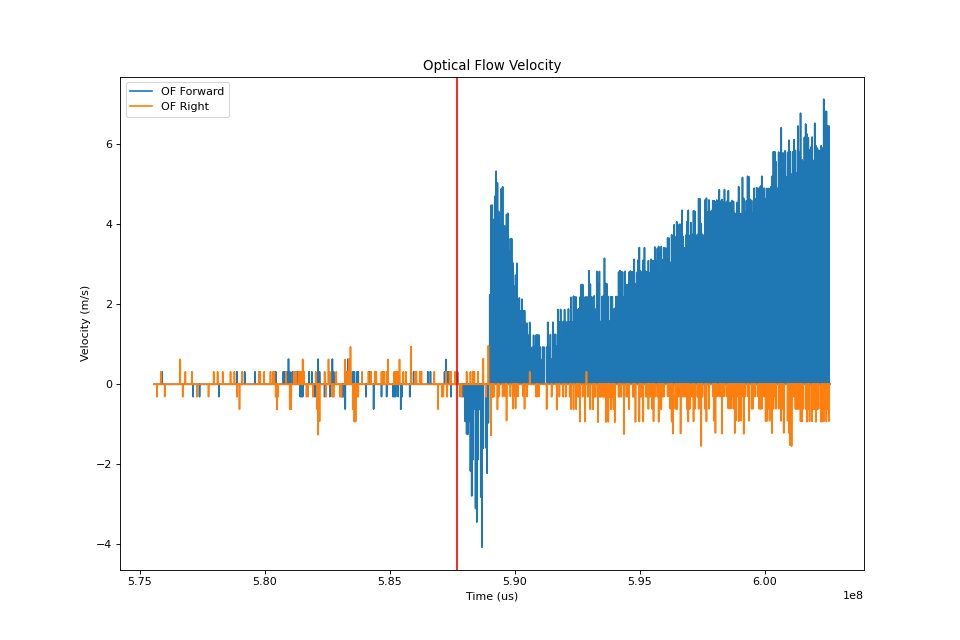

In [10]:
of = df[["frF", "frR", "rf"]]
of_vel = pd.DataFrame(data={"OF Forward":of.frF * of.rf/100,
                            "OF Right":of.frR * of.rf/100})

simple_time_plot(df.TimeUS,
                 of_vel,
                 atk=587680045,
                 title="Optical Flow Velocity",
                 units=["us","Velocity (m/s)"])

The OF and RF velocity is spikey with frequent returns to 0. An important
detail about the OF and RF derived velocity is the readings are absolute
velocity instead of change in velocity. In order to confirm OF and RF to
dead reckoning either the OF and RF readings need to be changed to their
change_in_signal equivalent or the dead reckoning will need to be integrated
for absolute velocity. Below we will start with integrating dead reckoning as
the frequent returns to 0 from the OF sensor will most likely cause issues with
monitoring the change in signal.

In [11]:
#TODO: Dead reckoning implementation

GPS from geodetic coordinates.

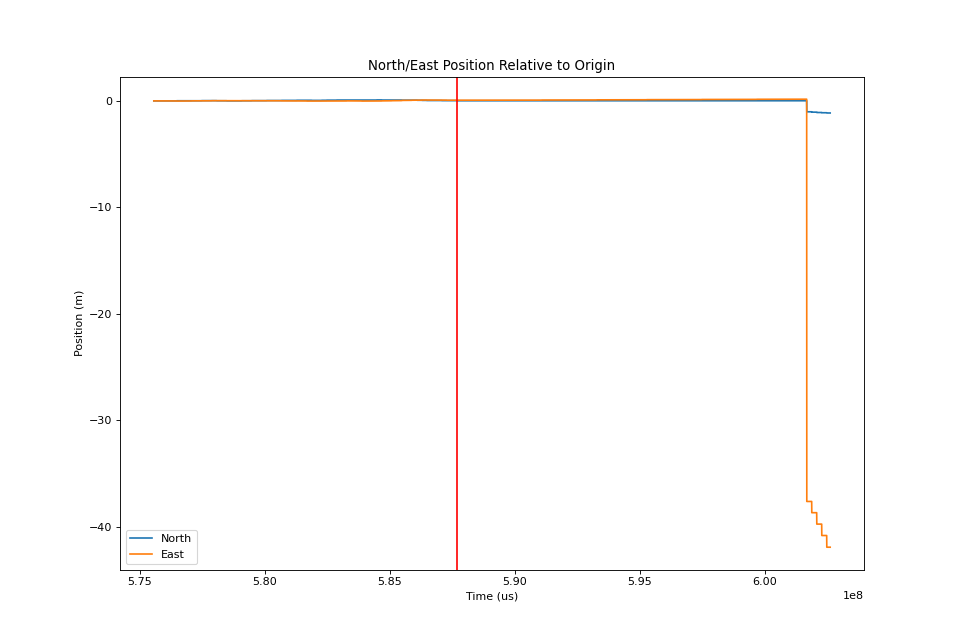

In [12]:
from confirmation.process import geodetic2ned

gps = df[["lat","lng","gpAlt"]]
gps_ned = geodetic2ned(gps.lat, gps.lng, gps.gpAlt)
simple_time_plot(df.TimeUS,
                 gps_ned[["North","East"]],
                 atk=587680045,
                title="North/East Position Relative to Origin",
                units=["us","Position (m)"])